# Imports

In [1]:
import pandas as pd
import dill
import numpy as np
import random
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

Переменные:

In [2]:
path = 'data'

files = ['ga_hits.csv', 'ga_sessions.csv', 'ga_hits.pkl', 'ga_sessions.pkl']

target_actions = ['sub_car_claim_click', 'sub_car_claim_submit_click',
                    'sub_open_dialog_click', 'sub_custom_question_submit_click',
                    'sub_call_number_click', 'sub_callback_submit_click', 
                    'sub_submit_success', 'sub_car_request_submit_click'
                 ]

organic_traffic = ['organic','referral', '(none)']

social_media = {'QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 
                'ISrKoXQCxqqYvAZICvjs', 'IZEXUFLARCUMynmHNBGo', 
                'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm'
               }

# Functions

In [3]:
# Вывод количества полностью заполенных объектов и их процент от выборки
def print_useful_rows_info(df):
    print('Количество полностью заполненных объектов из всей выборки:', len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки:', round(len(df.dropna()) / len(df) * 100, 2))

In [4]:
# Вывод количества пропущенных значений и их процента в выборке
def missing_values_info(df, column=None):
    if column == None:
        missing_values = ((df.isna().sum() / len(df)) * 100).sort_values()
        print('Процент пропущенных значений:\n', missing_values)
    else:
        print(f' Количество пропущенных значений: {len(df[df[column].isna()])}')
        print(f' Процент в выборке: {round((len(df[df[column].isna()]) / len(df)) * 100, 2)}')


# Data loading

Скачиваем данные в DataFrame

In [5]:
%%time
with open(f'{path}/{files[2]}', 'rb') as file:
    df_hits = dill.load(file)
    
with open(f'{path}/{files[3]}', 'rb') as file:
    df_sessions = dill.load(file)

Wall time: 12.7 s


In [6]:
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,None
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,None
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,None
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,None
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,None


In [7]:
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


# Data Preparation

## Описание данных

Узнаем размеры датафреймов.

In [8]:
df_hits.shape

(15726470, 11)

In [9]:
df_sessions.shape

(1860042, 18)

Выведем описательные статистики.

In [10]:
df_hits.describe(include='all')

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
count,15726470,15726470,6.566148e+06,1.572647e+07,15726470,9451666,15726470,15726470,15726470,11966286,0
unique,1734610,226,NaN,NaN,1,37873,342715,52,230,39825,0
top,5442565791571325612.1632449195.1632449195,2021-05-24,NaN,NaN,event,HbolMJUevblAbkHClEQa,podpiska.sberauto.com/,card_web,view_card,KclpemfoHstknWHFiLit,NaN
freq,768,513035,NaN,NaN,15726470,8879187,2793639,7456998,3558985,6505447,NaN
mean,NaN,NaN,2.091050e+05,2.356715e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,4.032110e+05,2.887713e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2.412000e+04,7.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,8.994100e+04,1.500000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2.195352e+05,2.900000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_sessions.describe(include='all')

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
count,1860042,1860042,1860042,1860042,1.860042e+06,1859945,1860042,1640439,1524427,777981,1860042,789904,1741364,16338,1860042,1860042,1860042,1860042
unique,1860042,1391719,226,85318,NaN,293,56,412,286,1219,3,13,206,104,5039,57,166,2548
top,9055434745589932991.1637753792.1637753792,1750498477.1629450062,2021-05-24,12:00:00,NaN,ZpYIoDJMcFzVoPFsHGJL,banner,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Apple,AuMdmADEIoPXiWpTsBEj,414x896,Chrome,Russia,Moscow
freq,1,462,39453,61067,NaN,578290,552272,463481,1006599,506819,1474871,464054,551088,9778,169090,1013436,1800565,805329
mean,NaN,NaN,NaN,NaN,2.712804e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.182907e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Проверим типы данных.

In [12]:
df_hits.dtypes

session_id         object
hit_date           object
hit_time          float64
hit_number          int64
hit_type           object
hit_referer        object
hit_page_path      object
event_category     object
event_action       object
event_label        object
event_value        object
dtype: object

In [13]:
df_sessions.dtypes

session_id                  object
client_id                   object
visit_date                  object
visit_time                  object
visit_number                 int64
utm_source                  object
utm_medium                  object
utm_campaign                object
utm_adcontent               object
utm_keyword                 object
device_category             object
device_os                   object
device_brand                object
device_model                object
device_screen_resolution    object
device_browser              object
geo_country                 object
geo_city                    object
dtype: object

Выведем атрибуты наших таблиц.

In [14]:
for i in df_hits.columns:
    print(i)

session_id
hit_date
hit_time
hit_number
hit_type
hit_referer
hit_page_path
event_category
event_action
event_label
event_value


In [15]:
for i in df_sessions.columns:
    print(i)

session_id
client_id
visit_date
visit_time
visit_number
utm_source
utm_medium
utm_campaign
utm_adcontent
utm_keyword
device_category
device_os
device_brand
device_model
device_screen_resolution
device_browser
geo_country
geo_city


Узнаем все общие атрибуты датафреймов.

In [16]:
print(set(df_hits.columns) & set(df_sessions.columns))

{'session_id'}


## Объединение таблиц

Для выполнения задачи, из таблицы `hits` интересует только информация о том, было ли достигнуто "целевое событие" типа «Оставить заявку» и «Заказать звонок». Добавим в таблицу новый атрибут `target`, в котором укажем "1", при наличии целевого события, и "0", при его отсутствии.

In [17]:
%%time
df_hits['target'] = df_hits.apply(lambda x: 1 if x.event_action in target_actions else 0, axis=1)

Wall time: 1min 42s


Проверим, что получилось

In [18]:
df_hits.target.value_counts()

0    15621562
1      104908
Name: target, dtype: int64

Нас интересуют только было ли целевое событие в определенную сессию или нет. Поэтому уберем все лишнее и избавимся от дубликатов. Оставим только уникальные значения в `session_id` и наш `target`, который показывает - было целевое событие в данную сессию или нет.

In [19]:
pivot_table = pd.pivot_table(df_hits, index=['session_id'], values=['target'], 
                             aggfunc={'target': [lambda x: 0 if x.sum() == 0 else 1]})
pivot_table

,target
,<lambda>
session_id,
1000009318903347362.1632663668.1632663668,0
1000010177899156286.1635013443.1635013443,0
1000013386240115915.1635402956.1635402956,0
1000017303238376207.1623489300.1623489300,0
1000020580299877109.1624943350.1624943350,0
...,...
999960188766601545.1626816843.1626816843,0
99996598443387715.1626811203.1626811203,0


In [20]:
df_hits_duplicated = pivot_table.reset_index(level=0)
df_hits_duplicated

,session_id,target
,,<lambda>
0,1000009318903347362.1632663668.1632663668,0
1,1000010177899156286.1635013443.1635013443,0
2,1000013386240115915.1635402956.1635402956,0
3,1000017303238376207.1623489300.1623489300,0
4,1000020580299877109.1624943350.1624943350,0
...,...,...
1734605,999960188766601545.1626816843.1626816843,0
1734606,99996598443387715.1626811203.1626811203,0
1734607,999966717128502952.1638428330.1638428330,0


In [21]:
df_hits_duplicated.columns = ['session_id', 'target']
df_hits_duplicated

,session_id,target
0,1000009318903347362.1632663668.1632663668,0
1,1000010177899156286.1635013443.1635013443,0
2,1000013386240115915.1635402956.1635402956,0
3,1000017303238376207.1623489300.1623489300,0
4,1000020580299877109.1624943350.1624943350,0
...,...,...
1734605,999960188766601545.1626816843.1626816843,0
1734606,99996598443387715.1626811203.1626811203,0
1734607,999966717128502952.1638428330.1638428330,0
1734608,999988617151873171.1623556243.1623556243,0


Проверим, все ли строки теперь уникальны.

In [22]:
df_hits_duplicated.session_id.describe()

count                                       1734610
unique                                      1734610
top       1000009318903347362.1632663668.1632663668
freq                                              1
Name: session_id, dtype: object

Проверим корректность преобразования в столбце `target`

In [23]:
df_hits_duplicated.target.value_counts()

0    1683850
1      50760
Name: target, dtype: int64

Узнаем размер, получившейся таблицы

In [24]:
df_hits_duplicated.shape

(1734610, 2)

выведем количество строк в датасете `df_sessions`

In [25]:
df_sessions.shape

(1860042, 18)

Посмотрим, есть ли различия в столбцах `session_id` у объединяемых таблиц

In [26]:
len(set(df_sessions.session_id) - set(df_hits_duplicated.session_id))

127776

In [27]:
len(set(df_hits_duplicated.session_id) - set(df_sessions.session_id))

2344

Посмотрим сколько общих строк в столбце `session_id` объединяемых таблиц

In [28]:
len(set(df_sessions.session_id) & set(df_hits_duplicated.session_id))

1732266

Датафрейм `df_sessions` содержит 127 776 уникальных сессий, а `df_hits_duplicate` - 2 344. Общих - 1 732 266.
Для получения качественной модели с хорошей предсказательной способностью, оставим только те сущности, у которых имеются все атрибуты, предполагающиеся на вход будущей модели, и известна целевая переменная. Потеря данных составит около 7% сущностей, не попавших под наши критерии.
Объединим таблицы методом `inner`.

In [29]:
%%time
df_joined = df_sessions.join(df_hits_duplicated.set_index('session_id'), on='session_id', how='inner')
df_joined.head()

Wall time: 1.69 s


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0


В глоссарии к тех.заданию имеется классификация трафика по типу привлечения на органический и платный, а так же выделяются визиты, привлеченные из социальных сетей.
Добавим несколько атрибутов:
`traffic` - здесь укажем значение "organic" для органического трафика и "paid" для платного;
`social_media` - для визитов из социальных сетей укажем - "yes", а для остальных - "no".

In [30]:
df_joined['traffic'] = df_joined.apply(
    lambda x: 'organic' if x.utm_medium in organic_traffic else 'paid', axis=1)

In [31]:
df_joined['social_media'] = df_joined.apply(
    lambda x: 'yes' if x.utm_source in social_media else 'no', axis=1)

Выведем первые 5 строк получившегося датасета

In [32]:
df_joined.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,...,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target,traffic,social_media
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0,paid,no
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,...,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0,paid,yes
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,...,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0,paid,no
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,...,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0,paid,no
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,...,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0,paid,no


In [33]:
with open(f'{path}/df_joined.pkl', 'wb') as file:
    dill.dump(df_joined, file)

## Data cleaning

In [34]:
with open(f'{path}/df_joined.pkl', 'rb') as file:
    df = dill.load(file)

### Обработка пропусков в данных

Выведем количество и процент полностью заполненных объектов из всей выборки.

In [35]:
print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 13829
Процент полностью заполненных объектов из всей выборки: 0.8


Выведим процент пропущенных значений по каждому атрибуту.

In [36]:
missing_values = missing_values_info(df)

Процент пропущенных значений:
 session_id                   0.000000
target                       0.000000
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
traffic                      0.000000
device_category              0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
client_id                    0.000000
social_media                 0.000000
utm_source                   0.004387
device_brand                 6.358030
utm_campaign                11.273500
utm_adcontent               17.557177
device_os                   58.533966
utm_keyword                 58.925823
device_model                99.130503
dtype: float64


Представим визуальный график заполненных значений

<AxesSubplot:>

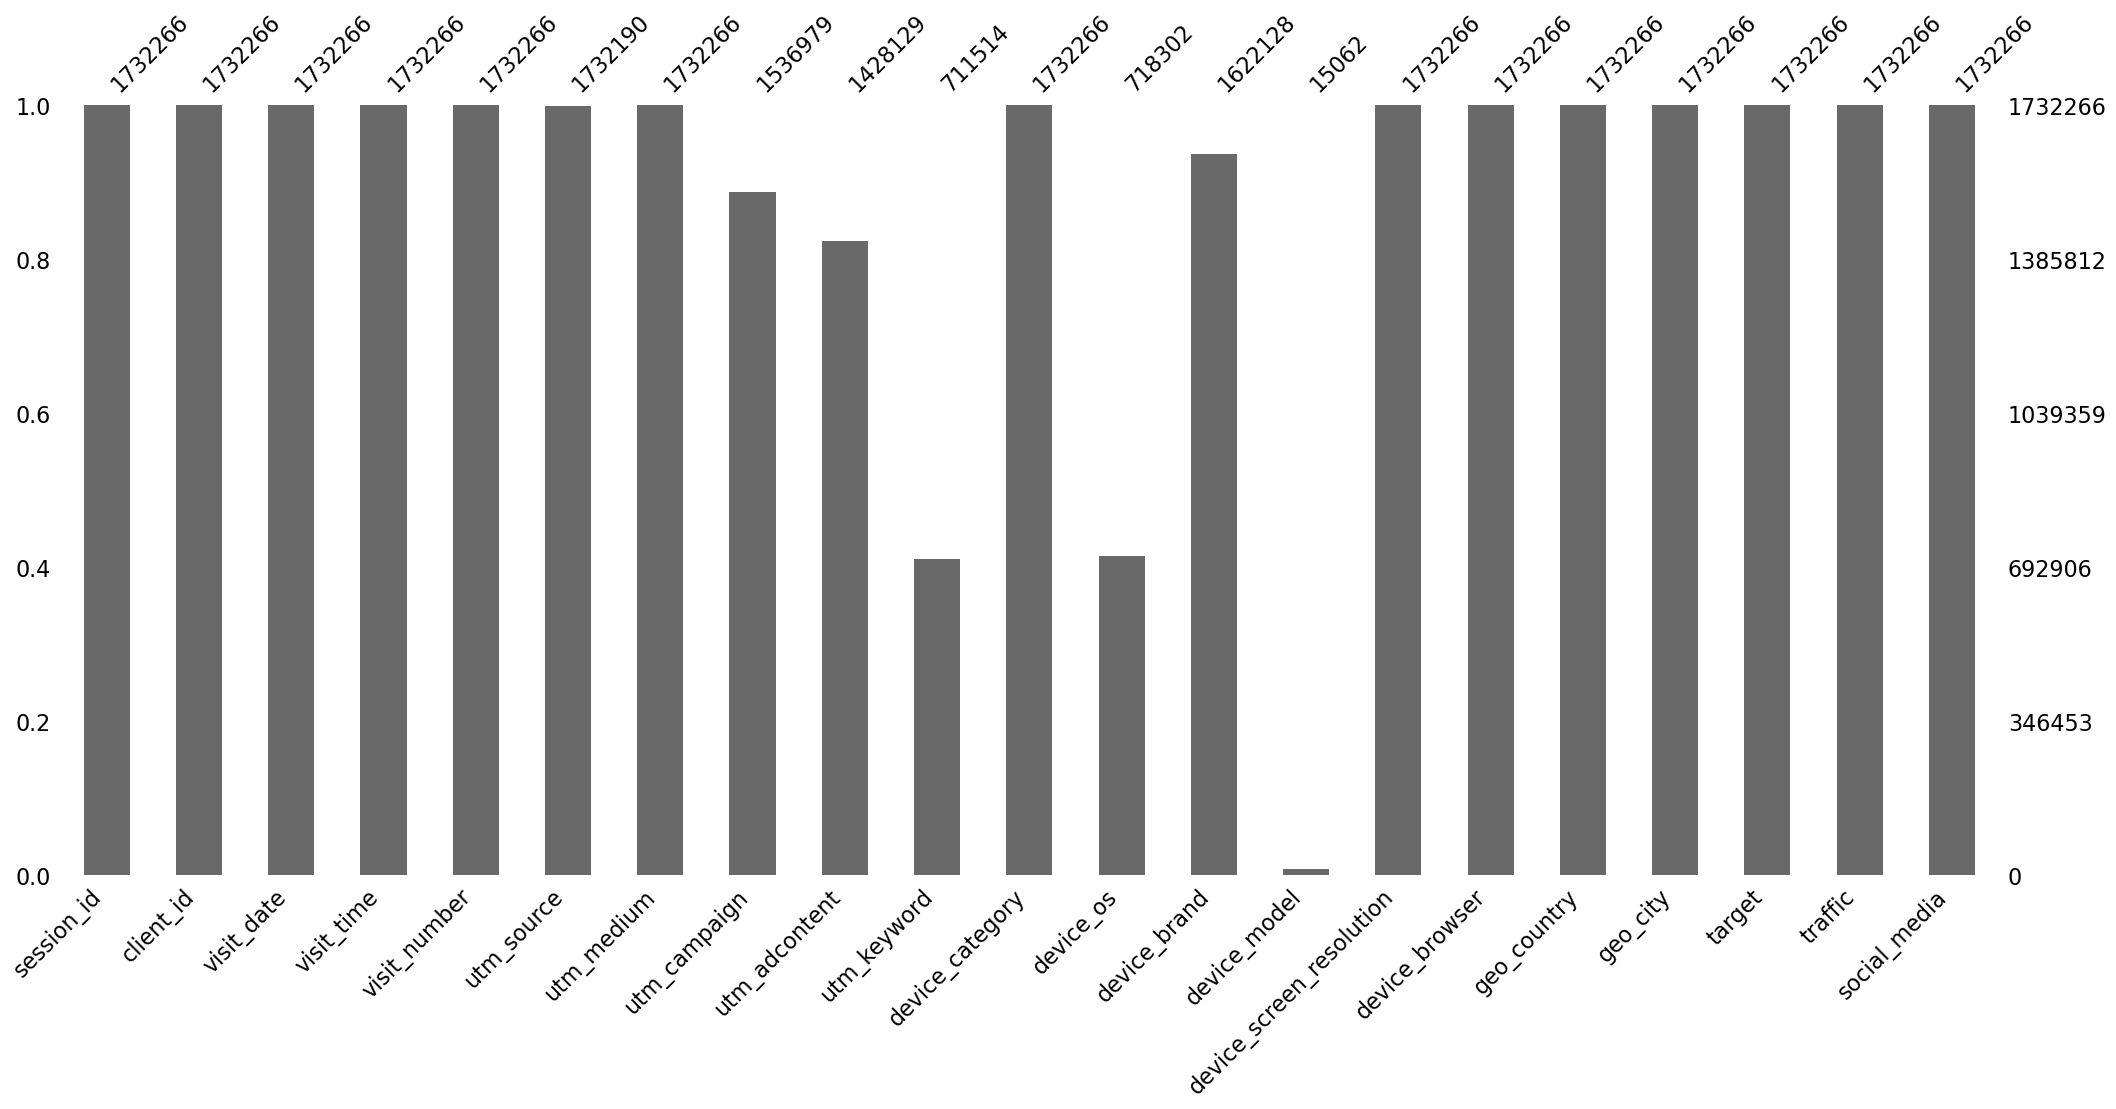

In [37]:
msno.bar(df)

Выведем матрицу пропусков.

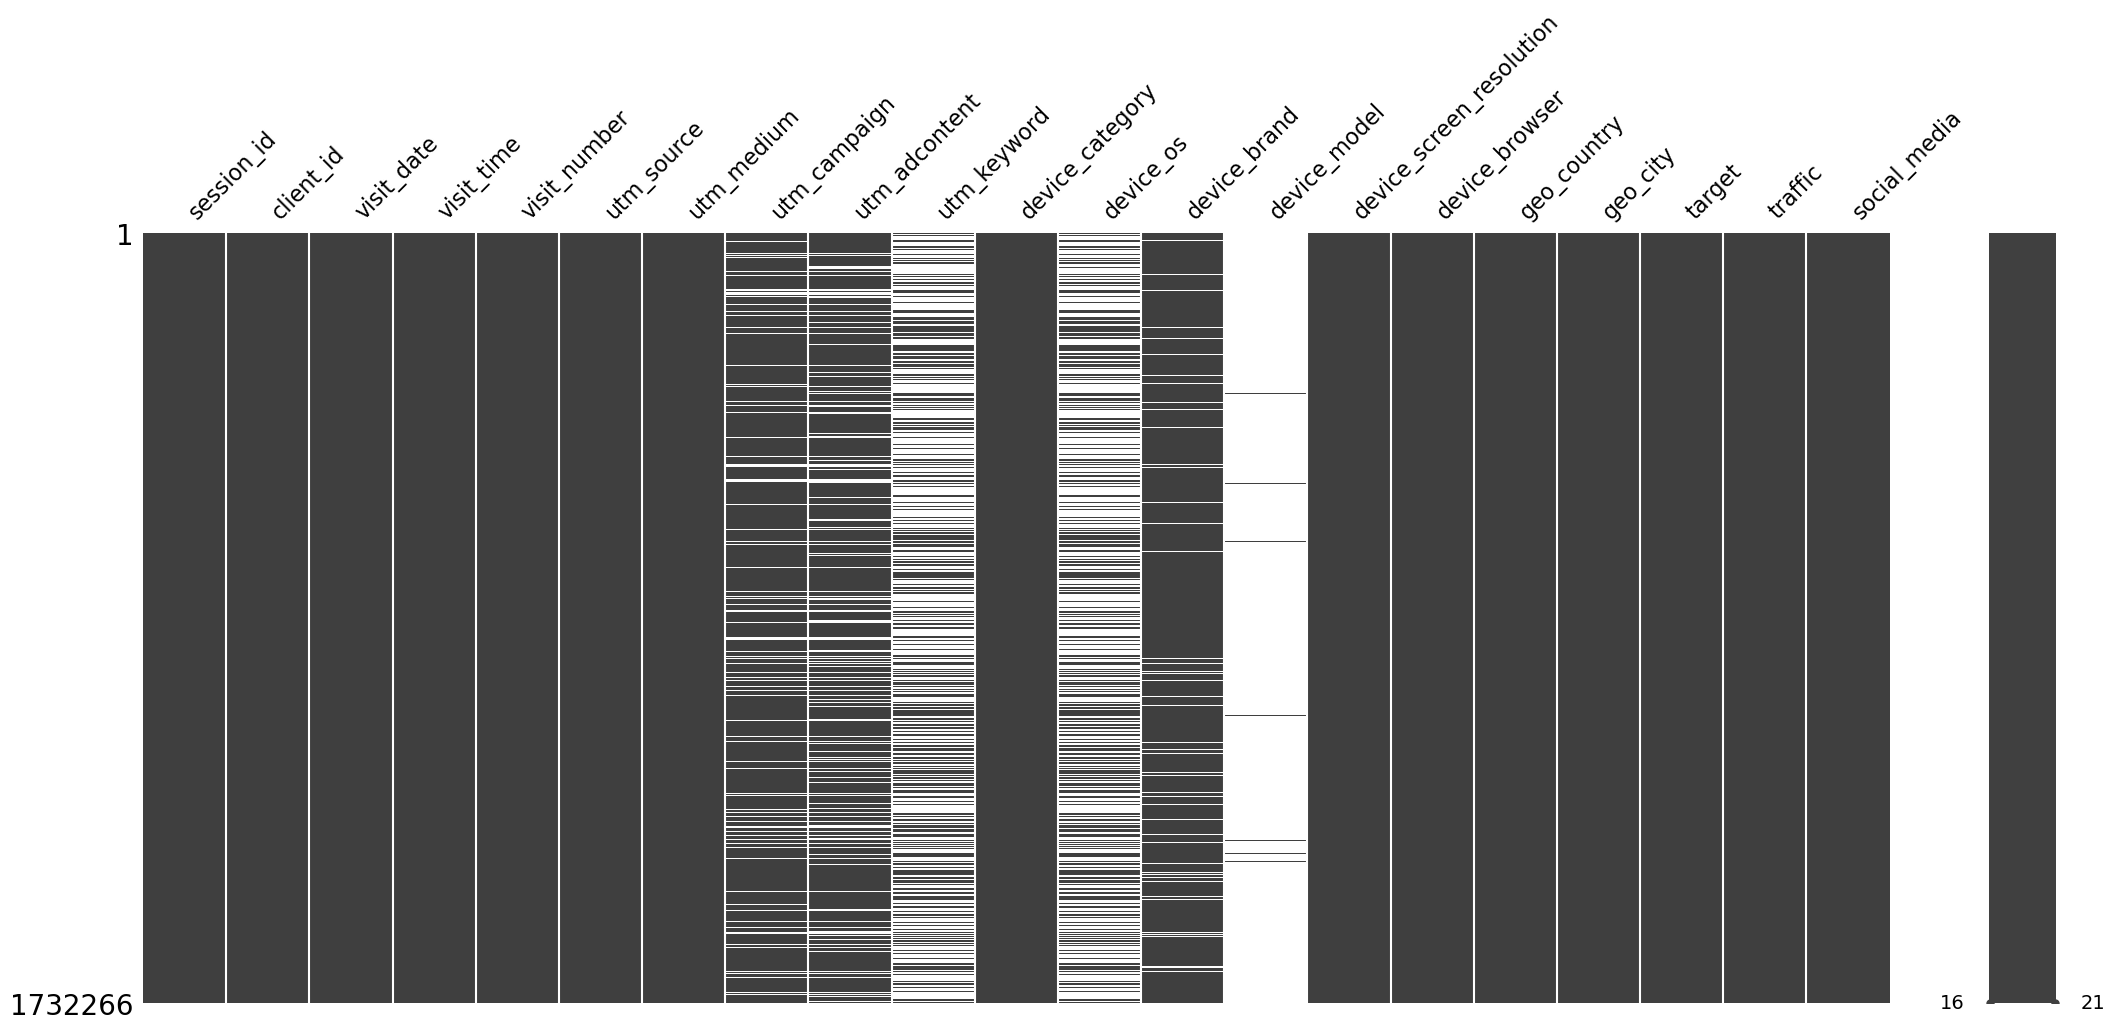

In [38]:
msno.matrix(df);

#### `device_model`, `utm_keyword`, `device_os`

Данный столбцы не информативны, так как процент их заполненности меньше 50%. Удалим эти столбцы.

In [100]:
df_cleaned = df.drop(['device_model', 'utm_keyword', 'device_os'], axis=1)
df_cleaned

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,traffic,social_media
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,0,paid,no
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,0,paid,yes
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0,paid,no
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0,paid,no
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0,paid,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,desktop,None,1920x1080,Chrome,Russia,Moscow,0,paid,no
1860038,9055421130527858185.1622007305.1622007305,2108379530.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,390x844,Safari,Russia,Stavropol,0,organic,no
1860039,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x667,Safari,Russia,Moscow,0,organic,no
1860040,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x851,Chrome,Russia,Chelyabinsk,0,paid,no


#### `device_brand`

Выведем количество пропусков в колонке `device_brand` и их процент от всей выборки.

In [101]:
missing_values_info(df_cleaned, 'device_brand')

 Количество пропущенных значений: 110138
 Процент в выборке: 6.36


Выведим список всех значений столбца `device_brand`.

In [102]:
df_cleaned.device_brand.unique().tolist()

['Huawei',
 'Samsung',
 'Xiaomi',
 'Apple',
 'Lenovo',
 None,
 'Vivo',
 'Meizu',
 '',
 'OnePlus',
 '(not set)',
 'BQ',
 'Realme',
 'OPPO',
 'itel',
 'Philips',
 'Nokia',
 'Alcatel',
 'LG',
 'Tecno',
 'Asus',
 'Infinix',
 'Sony',
 'ZTE',
 'Wiko',
 'Google',
 'Micromax',
 'Blackview',
 'Oukitel',
 'Motorola',
 'HOMTOM',
 'Cubot',
 'DOOGEE',
 'China Phone',
 'DEXP',
 'Neffos',
 'TP-Link',
 'Hisense',
 'Acer',
 'Vsmart',
 'BlackBerry',
 'Umidigi',
 'Leagoo',
 'Highscreen',
 'Ulefone',
 'Symphony',
 'LeEco',
 'Prestigio',
 'POCO',
 'Vestel',
 'Guophone',
 'Wileyfox',
 'HTC',
 'Vertex',
 'CAT',
 'InFocus',
 'TCL',
 'SonyEricsson',
 'Inoi',
 'Nomu',
 'Jiake',
 'ZOJI',
 'Mozilla',
 'Tele2',
 'H96',
 'Kyocera',
 'Karbonn',
 'BLU',
 'Haier',
 'Kingplay',
 'Sharp',
 'Coolpad',
 'MTC',
 'LeTV',
 'iNew',
 'Vernee',
 'A1',
 'Gionee',
 'General Mobile',
 'Digma',
 'Yota Devices',
 'Gome',
 'Egreat',
 'Kata',
 'Mito',
 'Poptel',
 'Flylion',
 'AGM',
 'SenseIT',
 'Archos',
 'Teclast',
 'Fly',
 'MLS',
 '

Как мы видим, помимо пустых значений None в столбце имеются еще неинформативные значения " ". Посчитаем их. 

In [103]:
len(df_cleaned[df_cleaned.device_brand == ''])

237058

Посмотрим к какой категории относятся пустые значения None и ''.

In [104]:
df_cleaned[(df_cleaned.device_brand.isna()) | (df_cleaned.device_brand == '')].device_category.value_counts(dropna=False)

desktop    346752
mobile        288
tablet        156
Name: device_category, dtype: int64

Узнаем, сколько всего строк с категорией desktop

In [105]:
len(df_cleaned[df.device_category == 'desktop'])

346891

Посмотрим, какие бренды имеют настольные устройства, где это известно

In [106]:
df_cleaned[df.device_category == 'desktop'][(df_cleaned.device_brand.notna()) & (df_cleaned.device_brand != '')].device_brand.unique().tolist()

C:\Users\1\AppData\Local\Temp\ipykernel_18108\3874192751.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cleaned[df.device_category == 'desktop'][(df_cleaned.device_brand.notna()) & (df_cleaned.device_brand != '')].device_brand.unique().tolist()


['Apple',
 'Xiaomi',
 'Samsung',
 'Huawei',
 'Flexymove',
 'Nokia',
 'Google',
 '(not set)',
 'Asus',
 'Beelink',
 'OPPO',
 'OnePlus',
 'Philips',
 'Realme']

Посмотрим какой у них браузер

In [107]:
df_cleaned[df_cleaned.device_brand.isna()].device_browser.value_counts(dropna=False)

Chrome                              63652
YaBrowser                           19205
Safari                              12660
Edge                                 5787
Firefox                              4840
Opera                                3530
Mozilla Compatible Agent              285
Samsung Internet                      100
MRCHROME                               23
Internet Explorer                       8
helloworld                              6
[FBAN                                   6
Instagram 212.0.0.38.119 Android        6
Maxthon                                 5
(not set)                               5
Instagram 216.1.0.21.137 Android        4
Instagram 213.0.0.29.120 Android        4
Android                                 3
Puffin                                  3
Coc Coc                                 2
UC Browser                              2
SeaMonkey                               1
Mozilla                                 1
Name: device_browser, dtype: int64

Как мы видим, марка устройства не указана практически во всех объектах категории 'desktop'.
Скорее всего это связано с тем, что зачастую настольный компьютер не имеет определенного производителя, так как состоит из комплектующих разных производителей. Заменим пропуски на значение `other`.

In [108]:
df_cleaned.device_brand = df_cleaned.device_brand.fillna('other')

In [109]:
df_cleaned.loc[df_cleaned['device_brand'] == '', 'device_brand'] = 'other'

Проверим, остались ли пустые строки в столбце `device_brand`

In [110]:
df_cleaned['device_brand'].isna().sum()

0

#### `utm_source`

Выведем количество пропущенных значений и процент их в выборке

In [111]:
missing_values_info(df_cleaned, 'utm_source')

 Количество пропущенных значений: 76
 Процент в выборке: 0.0


Процент пропущенных значений в столбце `utm_source` близок нулю, удалим строки с пропущенными значениями.

In [112]:
df_cleaned = df_cleaned[df_cleaned.utm_source.notna()]

#### `utm_campaign`

Выведем количество пропущенных значений и их процент в выборке

In [113]:
missing_values_info(df_cleaned, 'utm_campaign')

 Количество пропущенных значений: 195287
 Процент в выборке: 11.27


Выведем количество значений и описательные статистики

In [114]:
df_cleaned.utm_campaign.value_counts(dropna=False)

LTuZkdKfxRGVceoWkVyg    422965
LEoPHuyFvzoNfnzGgfcd    321286
FTjNLDyTrXaWYgZymFkV    234950
NaN                     195287
gecBYcKZCPMcVYdSSzKP    133247
                         ...  
qPDTdivQVeflLjTYIJnG         1
InOGyxvxAfYvSHCpIjJZ         1
ehLonfPENrOEoPTIyiOZ         1
YlsczTIyBSwTLNtuDkCd         1
cXxuwXPoQCvAXPHpFcZl         1
Name: utm_campaign, Length: 407, dtype: int64

In [115]:
df_cleaned.utm_campaign.describe()

count                  1536903
unique                     406
top       LTuZkdKfxRGVceoWkVyg
freq                    422965
Name: utm_campaign, dtype: object

In [116]:
422965/1536903*100

27.520604748640608

Пропущенных значений больше 10%, достаточно много чтобы удалить. В то же время есть частое значение, которое встречается в трети случаев. Разные рекламные кампании могли по разному себя показать и если заполнить пропуски модой, то можно случайно дать одной кампании больше веса при расчете модели, либо наоборот. Поэтому заполним пропущенные значения, значением 'other'.

In [117]:
df_cleaned.loc[df_cleaned.utm_campaign.isna(), 'utm_campaign'] = 'other'

In [118]:
missing_values_info(df_cleaned, 'utm_campaign')

 Количество пропущенных значений: 0
 Процент в выборке: 0.0


#### `utm_adcontent`

In [119]:
missing_values_info(df_cleaned, 'utm_adcontent')

 Количество пропущенных значений: 304101
 Процент в выборке: 17.56


Выведим количество значений и описательные статистики

In [120]:
df_cleaned.utm_adcontent.value_counts(dropna=False)

JNHcPlZPxEMWDnRiyoBf    935368
NaN                     304101
vCIpmpaGBnIQhyYNkXqp    179438
xhoenQgDQsgfEPYNPwKO    104381
PkybGvWbaqORmxjNunqZ     59038
                         ...  
zQEFTgQvqExfbldEpotc         1
JgmeMvxiYyrYlmqauiSv         1
aVjToAjFPhYtOzTWvULR         1
QMmfrhgnqNOwSTPaqlLK         1
oJivRDNIrrOckRBIKOtG         1
Name: utm_adcontent, Length: 281, dtype: int64

In [121]:
df_cleaned.utm_adcontent.describe()

count                  1428089
unique                     280
top       JNHcPlZPxEMWDnRiyoBf
freq                    935368
Name: utm_adcontent, dtype: object

Выведем записи, где атрибут не заполнен

In [122]:
df_cleaned[df_cleaned.utm_adcontent.isna()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,traffic,social_media
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,other,NaN,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0,paid,no
14,9055469620715506713.1636559415.1636559415,2108390820.1628883993,2021-11-10,18:50:15,4,SzZERoLMmrEUEhDaYcyN,cpc,other,NaN,mobile,Samsung,412x869,Android Webview,Russia,Saint Petersburg,0,paid,no
27,9055504865227535872.1639282176.1639282176,2108399026.1639282176,2021-12-12,07:09:36,1,BHcvLfOaCWvWTykYqHVe,cpc,other,NaN,mobile,Samsung,385x854,Chrome,Russia,Moscow,0,paid,no
37,905553874150070422.1639028885.1639028885,210840691.1639028886,2021-12-09,08:48:05,1,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,NaN,mobile,Apple,375x812,Safari,Russia,Moscow,0,paid,no
39,905553874150070422.1639041598.1639041598,210840691.1639028886,2021-12-09,12:19:58,4,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,NaN,mobile,Apple,375x812,Safari,Russia,Moscow,0,paid,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860018,9055329372850890545.1626351420.1626351420,2108358166.1626351409,2021-07-15,15:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,other,NaN,desktop,other,1920x1080,YaBrowser,Russia,Moscow,0,paid,no
1860020,9055329372850890545.1629287172.1629287172,2108358166.1626351409,2021-08-18,14:00:00,3,BHcvLfOaCWvWTykYqHVe,cpc,other,NaN,desktop,other,1920x1080,YaBrowser,Russia,Moscow,0,paid,no
1860031,9055387664158410361.1637729914.1637729914,2108371738.1637729913,2021-11-24,07:58:34,1,kjsLglQLzykiRbcDiGcD,cpc,RoDitORHdzGfGhNCyEMy,NaN,mobile,Apple,428x926,Safari,Russia,Moscow,0,paid,no
1860035,9055398929844789828.1624891784.1624891784,2108374361.1624891972,2021-06-28,17:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,vXsFkagGabkcWKlgLzSg,NaN,mobile,Samsung,320x676,Chrome,Russia,Naro-Fominsk,0,paid,no


В техническом задании нет описания данного атрибута, предположим, что он указывает на использование плагина "adcontent" для размещения объявлений. В таком случае пропуски означают, что пользователь привлечен без использования плагина. Заполним пропуски значением '(none)

In [123]:
df_cleaned.loc[df_cleaned.utm_adcontent.isna(), 'utm_adcontent'] = '(none)'

In [124]:
missing_values_info(df_cleaned, 'utm_adcontent')

 Количество пропущенных значений: 0
 Процент в выборке: 0.0


Проверим, остались ли еще пропущенные значения.

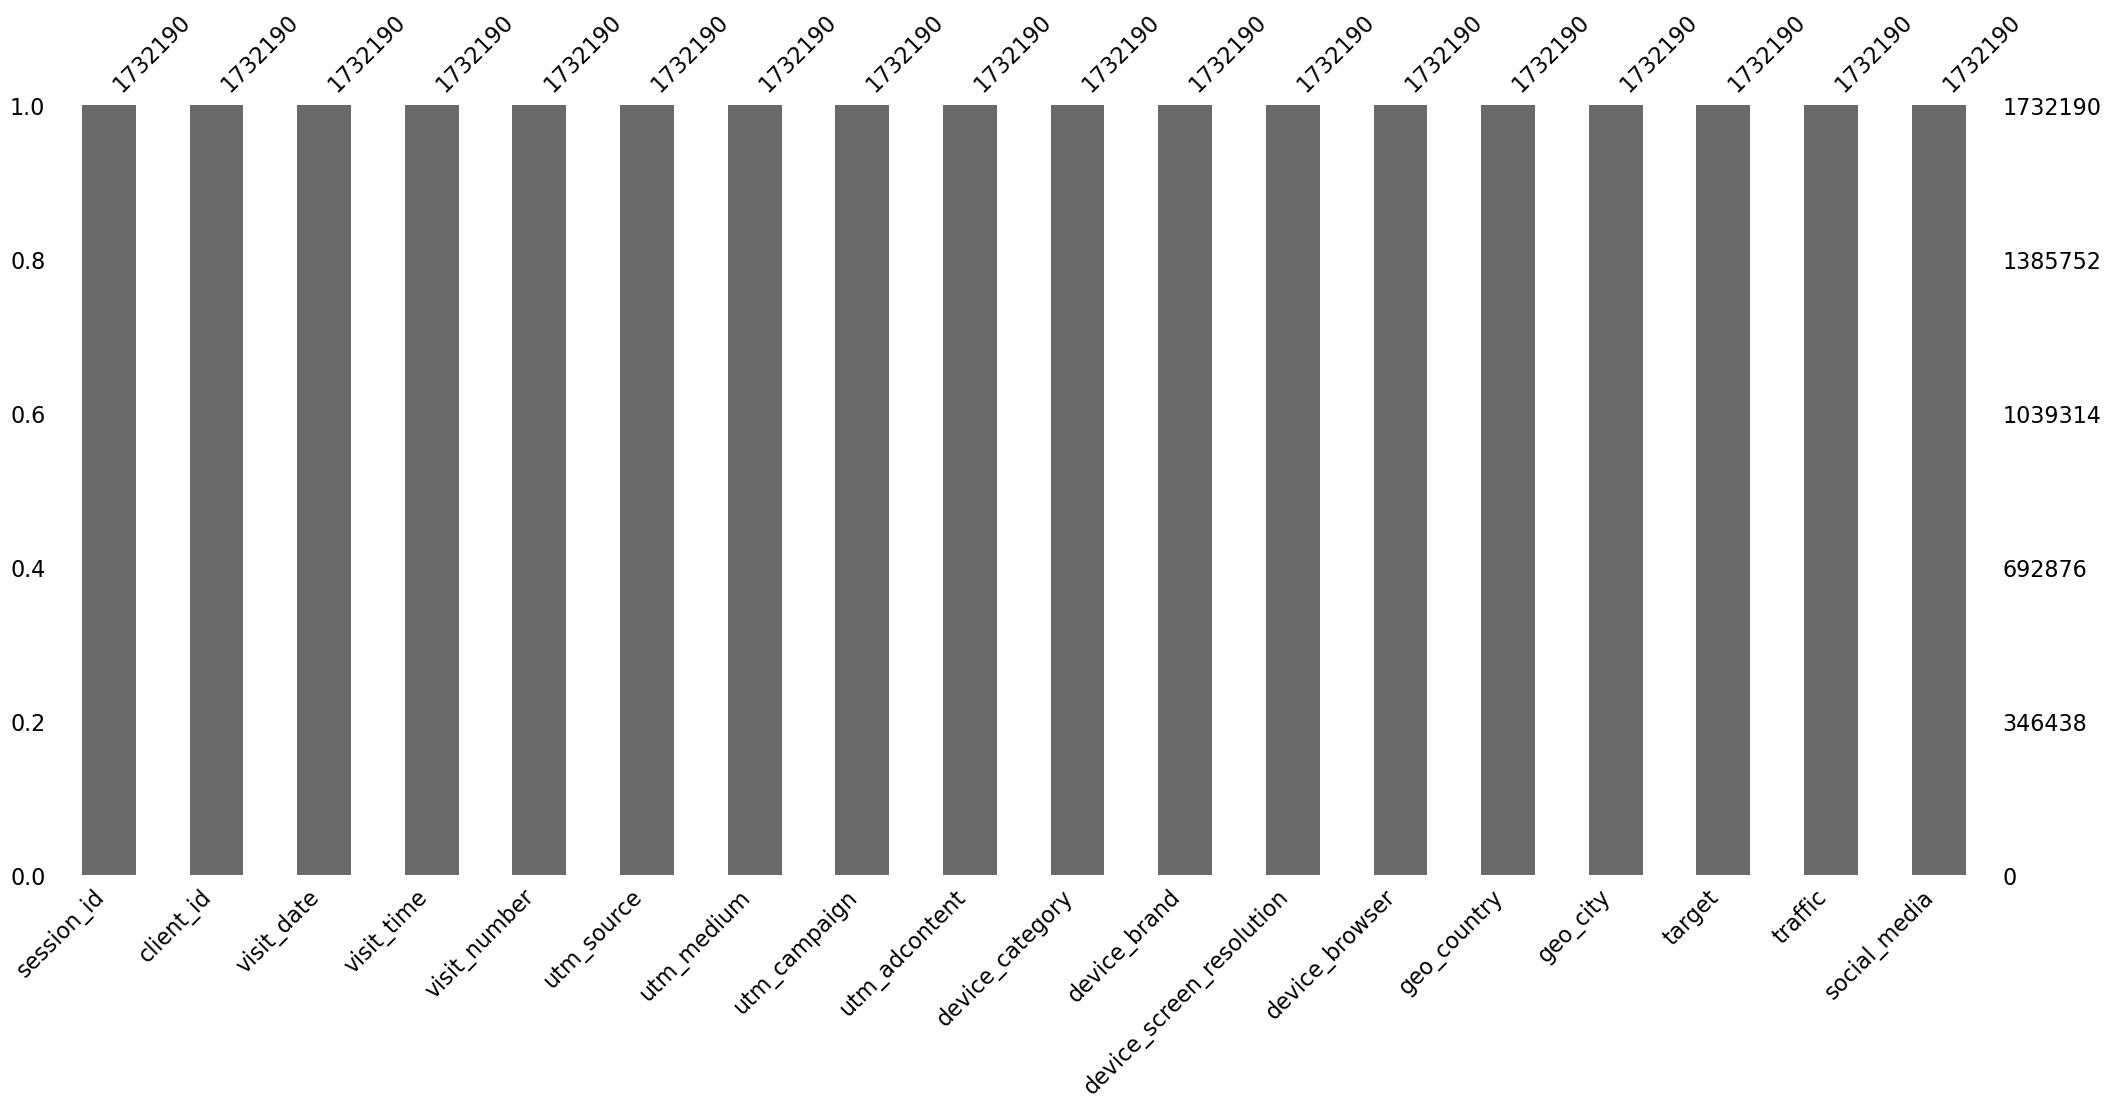

In [125]:
msno.bar(df_cleaned);

In [126]:
missing_values_info(df_cleaned)

Процент пропущенных значений:
 session_id                  0.0
target                      0.0
geo_city                    0.0
geo_country                 0.0
device_browser              0.0
device_screen_resolution    0.0
device_brand                0.0
device_category             0.0
utm_adcontent               0.0
utm_campaign                0.0
utm_medium                  0.0
utm_source                  0.0
visit_number                0.0
visit_time                  0.0
visit_date                  0.0
client_id                   0.0
traffic                     0.0
social_media                0.0
dtype: float64


### Устранение дубликатов

Проверим, имеются ли дублирующиеся значения.

In [127]:
df_cleaned[df_cleaned.duplicated()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,traffic,social_media


Дублирующихся значений нет.

После создания столбцов "traffic" и "social_media", остались косвенно дублирующие значения в столбцах "utm_medium" и "utm_source" - удалим их.

In [128]:
df_cleaned.drop(columns=["utm_medium", "utm_source"], inplace=True, axis=1)

C:\Users\1\AppData\Local\Temp\ipykernel_18108\2846655102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(columns=["utm_medium", "utm_source"], inplace=True, axis=1)


### Преобразование типов данных

Проверим типы данных

In [136]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1732190 entries, 0 to 1860041
Data columns (total 16 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_campaign              object
 6   utm_adcontent             object
 7   device_category           object
 8   device_brand              object
 9   device_screen_resolution  object
 10  device_browser            object
 11  geo_country               object
 12  geo_city                  object
 13  target                    int64 
 14  traffic                   object
 15  social_media              object
dtypes: int64(2), object(14)
memory usage: 224.7+ MB


In [137]:
df_cleaned.iloc[0]

session_id                  9055434745589932991.1637753792.1637753792
client_id                                       2108382700.1637753791
visit_date                                                 2021-11-24
visit_time                                                   14:36:32
visit_number                                                        1
utm_campaign                                     LEoPHuyFvzoNfnzGgfcd
utm_adcontent                                    vCIpmpaGBnIQhyYNkXqp
device_category                                                mobile
device_brand                                                   Huawei
device_screen_resolution                                      360x720
device_browser                                                 Chrome
geo_country                                                    Russia
geo_city                                                     Zlatoust
target                                                              0
traffic             

Столбцы 'visit_date' и 'visit_time' содержат дату и время визита клиента, но имеют тип данных 'object'. Проверим, имеют ли они тип 'datetime', попробуем вывести день и час первой строки.

In [138]:
df_cleaned.visit_date[0].day

24

In [139]:
df_cleaned.visit_time[0].hour

14

Типы данных приведены верно, преобразований не требуется.

In [140]:
df_types = df_cleaned.copy()

Столбцы "traffic" и "social_media" могут принимать только по два значения и являются категориальными. Изменим их тип на категориальный.

In [145]:
df_types['traffic'] = df_types.traffic.astype('category')
df_types['social_media'] = df_types.social_media.astype('category')

Посмотрим сколько значений принимает столбец "device_category"

In [154]:
df_types.device_category.value_counts()

mobile     1368651
desktop     346843
tablet       16696
Name: device_category, dtype: int64

столбец "device_category" принимает всего 3 значения, список исчерпывающий, следовательно можем так же изменить тип на категориальный.

In [155]:
df_types['device_category'] = df_types.device_category.astype('category')

Оставшиеся переменные, которые будем использовать в модели качественные, но их список значений может быть не окончен, поэтому не будем изменять их тип на категориальный.

In [159]:
# выведем результат преобразований типов
df_types.dtypes

session_id                    object
client_id                     object
visit_date                    object
visit_time                    object
visit_number                   int64
utm_campaign                  object
utm_adcontent                 object
device_category             category
device_brand                  object
device_screen_resolution      object
device_browser                object
geo_country                   object
geo_city                      object
target                         int64
traffic                     category
social_media                category
dtype: object

In [160]:
# сохраним датафрейм
with open(f'{path}/df_cleaned.pkl', 'wb') as file:
    dill.dump(df_types, file)

# Data visualization

In [3]:
# загрузим датафрейм
with open(f'{path}/df_cleaned.pkl', 'rb') as file:
    df = dill.load(file)

По заданию необходимо ознакомиться с распределением ключевых атрибутов.
Ключевыми атрибутами являются все атрибуты, типа `utm_*`, `device_*`, `geo_*`.

Выведем список ключевых аттрибутов

In [162]:
key_cols = []
for i in df.columns.tolist():
    if i[:3] in ['utm', 'dev', 'geo']:
        key_cols.append(i)
key_cols        

['utm_campaign',
 'utm_adcontent',
 'device_category',
 'device_brand',
 'device_screen_resolution',
 'device_browser',
 'geo_country',
 'geo_city']

Так как у нас большинство аттрибутов качественные, в основном будем выводить графики в виде столбчатых диаграмм. 
Для наглядности как в абсолютных так и процентных значениях. 
Для удобства напишем функцию.

In [6]:
def bar_graf(df, column, xlabel, title, ylabel='частота'):
    
    pivot = df.groupby([column], as_index=False)['session_id'].count()
    pivot = pivot.rename(columns={'session_id': 'count'})
    pivot['percent'] = round(pivot['count'] / pivot['count'].sum() * 100, 1)
    pivot = pivot.sort_values('count', ascending=False)
    print(pivot)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 8), nrows=1, ncols=2)
    
    ax1.bar(pivot[column], pivot['count'], color=['green', 'red'])
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    
    ax2.bar(pivot[column], pivot['percent'], color=['green', 'red'])
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(f'{ylabel} в %')   
    
    fig.suptitle(title)

Согласно заданию, имеет значение отношение канала привлечения к социальным сетям. Построим столбчатую диаграмму распределения по каналу привлечения, отражающую соотношения количества привлеченных посетителей из социальных сетей и других каналов привлечения.

  social_media    count  percent
0           no  1475910     85.2
1          yes   256280     14.8


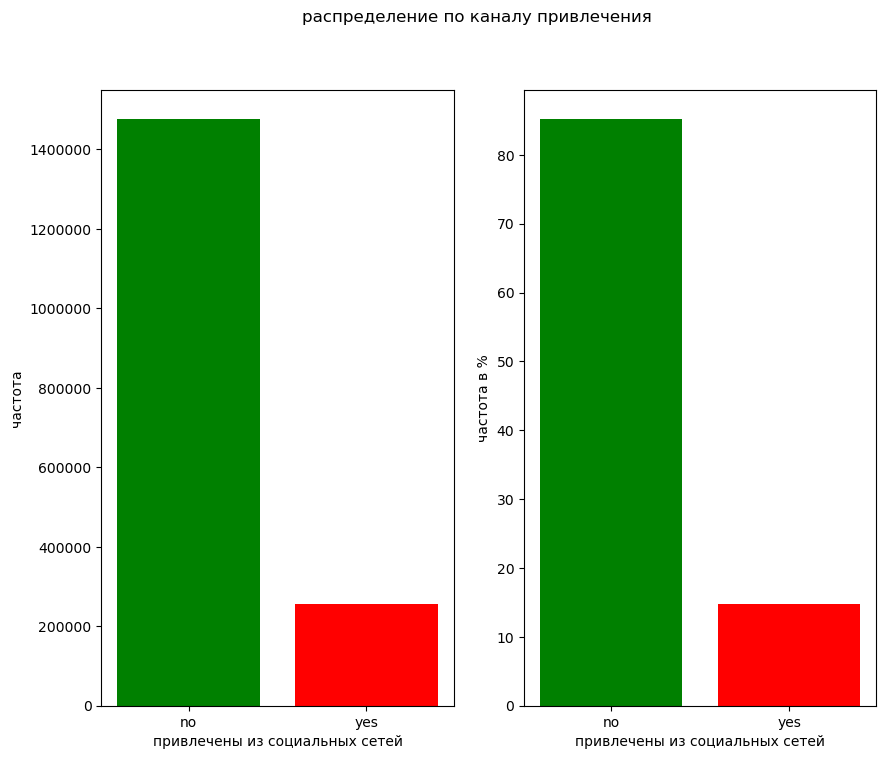

In [10]:
bar_graf(df=df, 
         column='social_media', 
         xlabel='привлечены из социальных сетей', 
         title='распределение по каналу привлечения', 
         ylabel='частота')

_Согласно графику, только около 15 процентов посетителей были привлечены через социальные сети. Основная масса привлечена через другие каналы_

По типу привлечения посетителей, трафик различается на органический и платный. Построим столбчатую диаграмму их соотношения.

   traffic    count  percent
1     paid  1263270     72.9
0  organic   468920     27.1


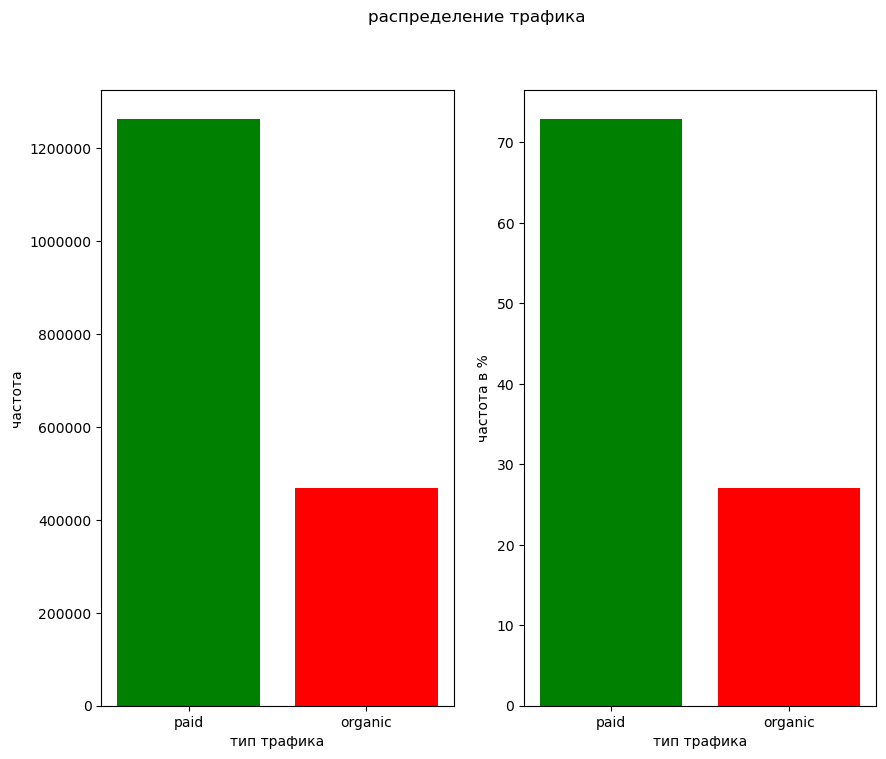

In [11]:
bar_graf(df=df, 
         column='traffic', 
         xlabel='тип трафика', 
         title='распределение трафика', 
         ylabel='частота')

_По большей части посетители были привлечены через платный трафик - почти 3/4 визитов. Данное обстоятельство говорит что проводимые рекламные компании обеспечивают высокий трафик посетителей на сайт_

Посмотрим на распределение визитов с целевым действием по странам привлечения.

      geo_country  count  percent
53         Russia  49151     97.7
69        Ukraine    199      0.4
26        Germany     78      0.2
72  United States     64      0.1
9         Belarus     59      0.1
..            ...    ...      ...
33           Iran      1      0.0
10        Belgium      1      0.0
35        Ireland      1      0.0
47        Nigeria      1      0.0
74        Vietnam      1      0.0

[75 rows x 3 columns]


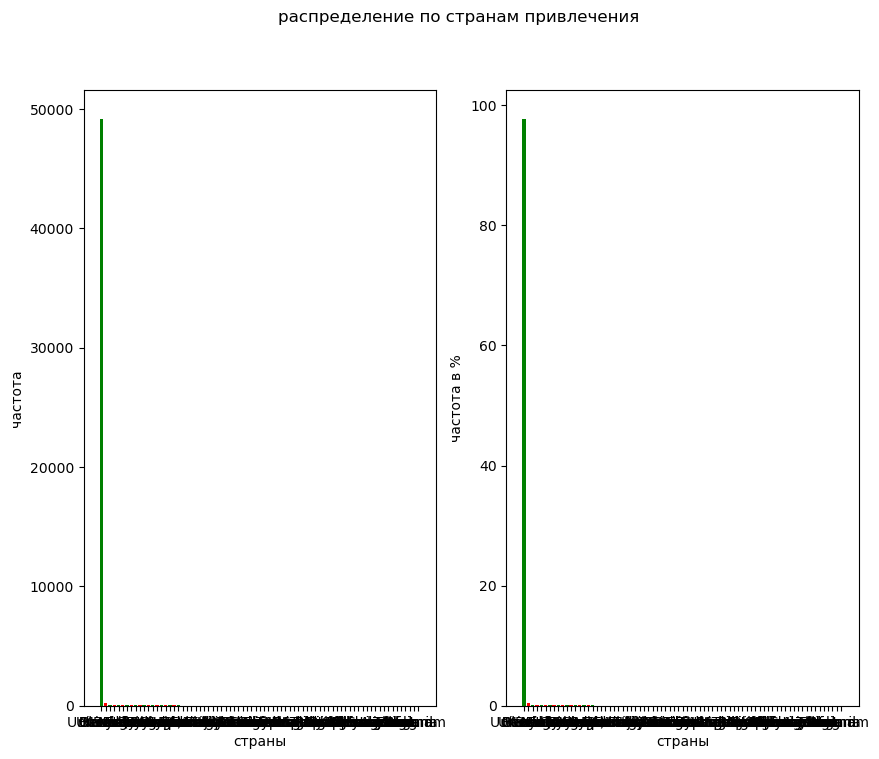

In [12]:
# диаграмма распределения целевых действий по столбцу "geo_country"
bar_graf(df=df[df.target == 1], 
         column='geo_country', 
         xlabel='страны', 
         title='распределение по странам привлечения', 
         ylabel='частота')

_практически все визиты окончившиеся целевым действием были привлечены из России, это объясняется тем, что сервис оказаывается на данной территории_

Посмотрим на распределение целевых действий по городам России

             geo_city  count  percent
168            Moscow  23625     48.1
245  Saint Petersburg   7113     14.5
0           (not set)   1361      2.8
93              Kazan   1139      2.3
130         Krasnodar   1081      2.2
..                ...    ...      ...
190    Novaya Adygeya      1      0.0
79            Iskitim      1      0.0
264           Shatura      1      0.0
148           Lipitsy      1      0.0
180        Neftekamsk      1      0.0

[360 rows x 3 columns]


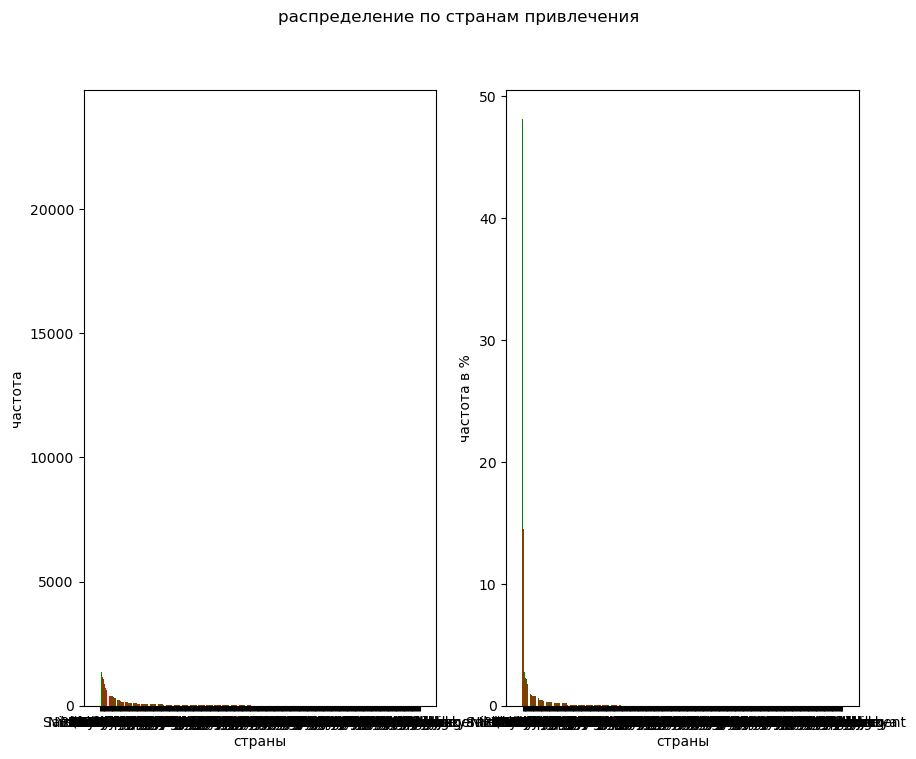

In [13]:
# диаграмма распределения целевых действий по городам России
bar_graf(df=df[(df.target == 1) & (df.geo_country == 'Russia')], 
         column='geo_city', 
         xlabel='страны', 
         title='распределение по странам привлечения', 
         ylabel='частота')

_Как и следовало ожидать основные клиенты приходят из столичных городов Москвы и Петербурга. Отсортируем список и выведем первые 20 записей_

In [52]:
pivot = df[(df.target == 1) & (df.geo_country == 'Russia')].groupby(['geo_city'], as_index=False)['session_id'].count()
pivot = pivot.rename(columns={'session_id': 'count'})
pivot['percent'] = round(pivot['count'] / pivot['count'].sum() * 100, 1)
print(pivot.sort_values('count', ascending=False)[:20])

             geo_city  count  percent
168            Moscow  23625     48.1
245  Saint Petersburg   7113     14.5
0           (not set)   1361      2.8
93              Kazan   1139      2.3
130         Krasnodar   1081      2.2
344     Yekaterinburg    887      1.8
248            Samara    727      1.5
306               Ufa    639      1.3
186   Nizhny Novgorod    559      1.1
199       Novosibirsk    509      1.0
300              Tula    438      0.9
76             Grozny    401      0.8
240     Rostov-on-Don    397      0.8
46        Chelyabinsk    396      0.8
134       Krasnoyarsk    376      0.8
20         Balashikha    359      0.7
78            Irkutsk    327      0.7
273             Sochi    316      0.6
332          Voronezh    282      0.6
57         Domodedovo    263      0.5


_все города из списка являются административными центрами субъектов РФ. Запомним это и используем в фич-инжиниринге_

Посмотрим на распределение целевых действий в зависимости от разрешения экрана используемых устройств.

    device_screen_resolution  count  percent
347                  414x896   4397      8.7
113                1920x1080   3577      7.1
246                  375x812   3168      6.3
305                  393x851   2932      5.8
340                  412x915   2667      5.3
..                       ...    ...      ...
143                2926x1646      1      0.0
348                  414x897      1      0.0
141                2561x1440      1      0.0
140                2560x1707      1      0.0
0                   1000x600      1      0.0

[493 rows x 3 columns]


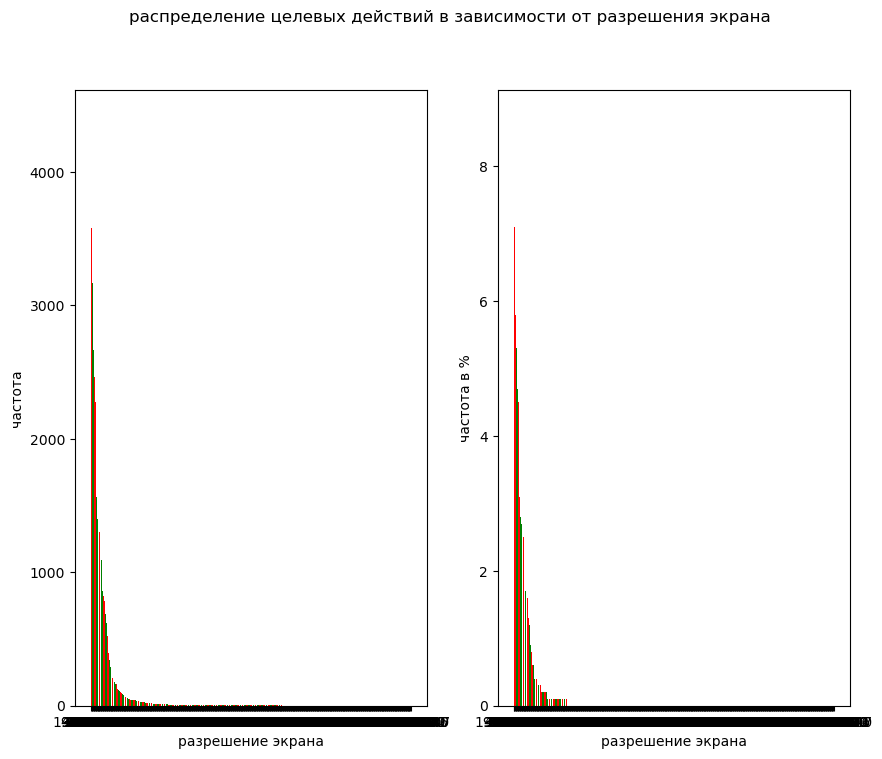

In [7]:
# диаграмма распределения целевых действий в зависимости от разрешения экрана
bar_graf(df=df[df.target == 1], 
         column='device_screen_resolution', 
         xlabel='разрешение экрана', 
         title='распределение целевых действий в зависимости от разрешения экрана', 
         ylabel='частота')

_прослеживается явная зависимость наличия целевого действия от разрешения экрана.
Дополнительно посмотрим к каким маркам относятся пять первых, по частоте, разрешения._

In [91]:
pivot = df[df.target == 1].groupby(['device_screen_resolution'], as_index=False)['session_id'].count()
pivot = pivot.rename(columns={'session_id': 'count'})
pivot['percent'] = round(pivot['count'] / pivot['count'].sum() * 100, 1)
pivot = pivot.sort_values('count', ascending=False)
top_screen_resolution = pivot['device_screen_resolution'][:5]
top_screen_resolution

347      414x896
113    1920x1080
246      375x812
305      393x851
340      412x915
Name: device_screen_resolution, dtype: object

In [92]:
df[(df['device_screen_resolution'].isin(list(top_screen_resolution))) & df.target == 1].device_brand.value_counts()

Apple        7525
other        3641
Xiaomi       2874
Samsung      2610
Google         35
Nokia          20
(not set)      15
Motorola        8
Asus            6
OnePlus         4
ZTE             2
Lenovo          1
Name: device_brand, dtype: int64

_такие разрешения экрана имеют топовые марки устройств, что можно объяснить финансовой состоятельностью их владельцев.
Дополнительно выведем распределение целевых действий в зависимости от марки устройства._

   device_brand  count  percent
4         Apple  14467     28.8
66        other  11515     22.9
49      Samsung  10053     20.0
62       Xiaomi   6592     13.1
23       Huawei   4518      9.0
..          ...    ...      ...
35       Motive      1      0.0
47        Razer      1      0.0
45      Philips      1      0.0
7     Black Fox      1      0.0
33     Micromax      1      0.0

[67 rows x 3 columns]


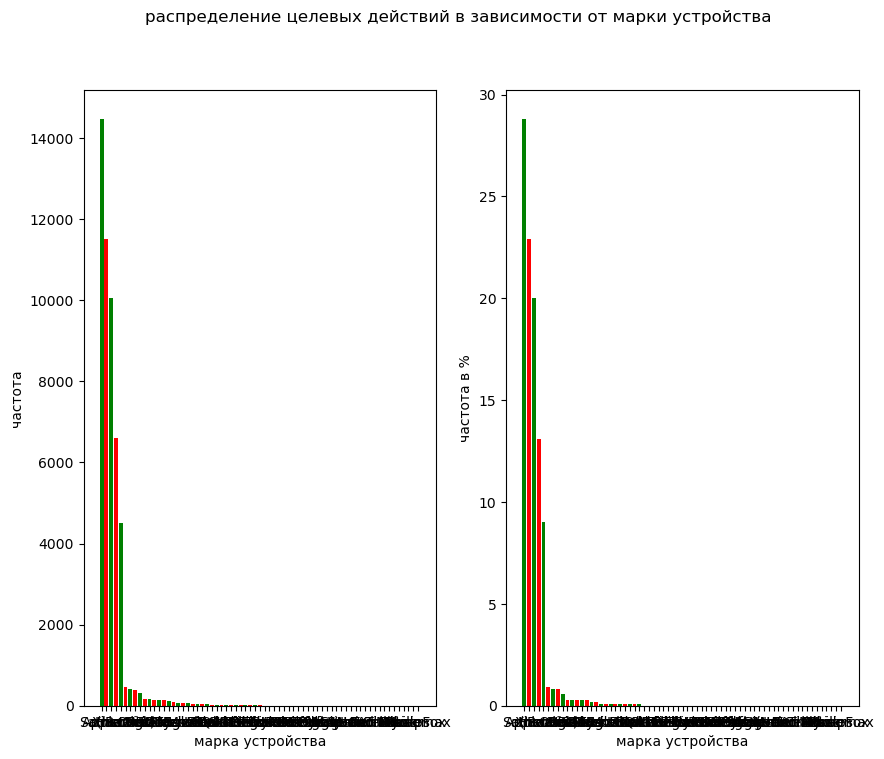

In [8]:
# диаграмма распределения целевых действий в зависимости от марки устройства
bar_graf(df=df[df.target == 1], 
         column='device_brand', 
         xlabel='марка устройства', 
         title='распределение целевых действий в зависимости от марки устройства', 
         ylabel='частота')

_Первые 4 марки те же, что может говорить о корреляции между разрешением экрана и маркой устройства. Следует отметить то, что чаще целевые действия совершают владельцы девайсов более дорогих брендов Apple и Samsung._

Создадим столбчатую диаграмму распределения по категориям. Посмотрим, какие устройства используют чаще.

  device_category    count  percent
1          mobile  1368651     79.0
0         desktop   346843     20.0
2          tablet    16696      1.0


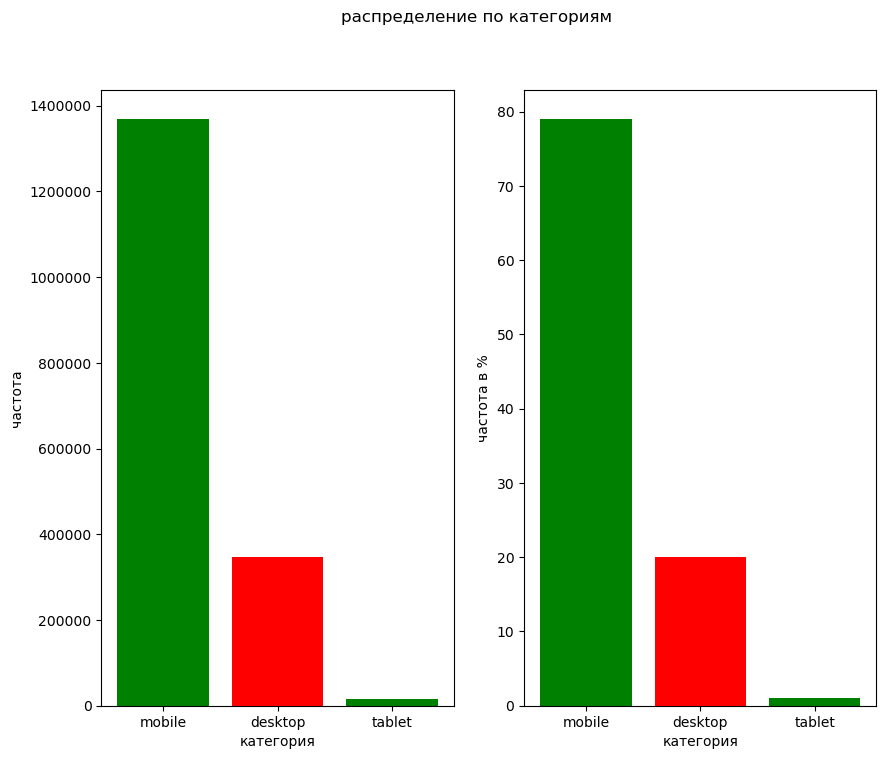

In [9]:
bar_graf(df=df, 
         column='device_category', 
         xlabel='категория', 
         title='распределение по категориям', 
         ylabel='частота')

_Чаще всего для входа на сайт используются мобильные устройства (79%), реже настольные устройства, всего 20%. Планшетные устройства используются крайне редко. Имеет смысл оптимизировать сайт под мобильные устройства._

Построим диаграмму распределения по наличию целевого действия.

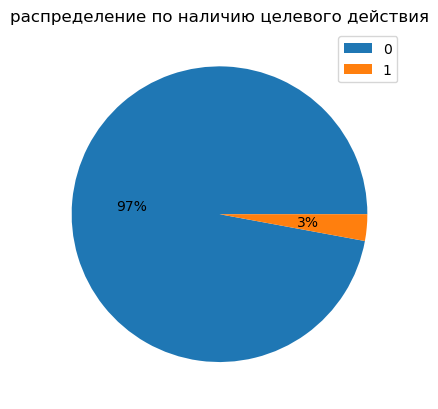

   target    count
0       0  1681881
1       1    50309


In [168]:
stats_target = df.groupby(['target'], as_index=False)['session_id'].count()
stats_target = stats_target.rename(columns={'session_id': 'count'})

plt.pie(stats_target['count'], labels=stats_target['target'], labeldistance=None, autopct='%1.0f%%')
plt.legend()
plt.title('распределение по наличию целевого действия')
plt.show();

print(stats_target)

Всего 3% визитов конверсируется в целевое действие. Подавляющей части посетителей возможно не интересен предлагаемый продукт. Необходимо проверить, охватывают ли проводимые рекламные компании нашу целевую группу.

Посмотрим какая конверсия визитов в зависимости от вида трафика

In [169]:
stats_traffic = pd.pivot_table(df,
                               index='traffic',
                               columns ='target',
                               values='session_id',
                               aggfunc='count'
                              )
stats_traffic['perc'] = stats_traffic[1] / (stats_traffic[0] + stats_traffic[1]) *100
stats_traffic['traffic'] = stats_traffic.index

stats_traffic

target,0,1,perc,traffic
traffic,,,,
organic,448108,20812,4.438284,organic
paid,1233773,29497,2.334972,paid


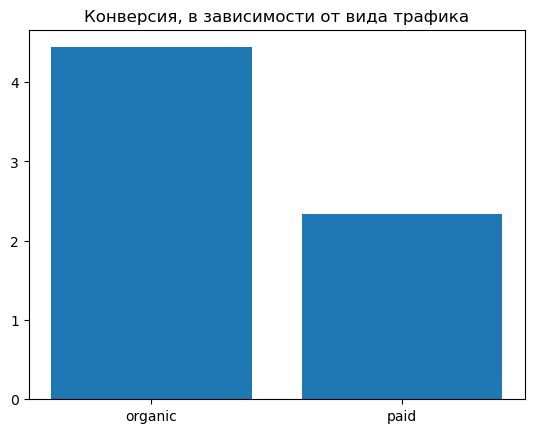

In [170]:
plt.bar(stats_traffic['traffic'], stats_traffic['perc'])
plt.title('Конверсия, в зависимости от вида трафика');

_Конверсия в целевое действие органического трафика выше, что объясняется целенаправленными визитами на сайт_

Посмотрим на соотношение видов трафика, среди визитов с целевыми действиями.

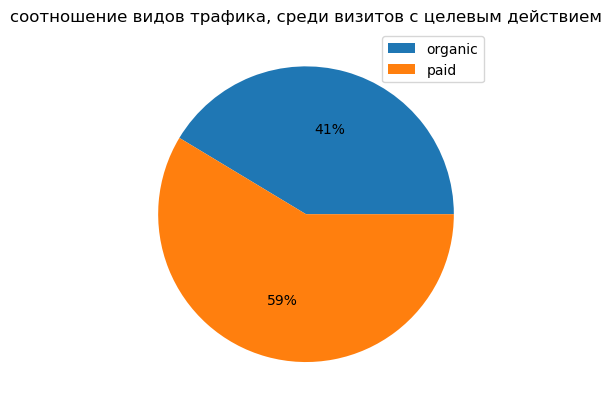

   traffic  count
0  organic  20812
1     paid  29497


In [171]:
stats_target = df[df_cleaned['target'] == 1].groupby(['traffic'], as_index=False)['session_id'].count()
stats_target = stats_target.rename(columns={'session_id': 'count'})

plt.pie(stats_target['count'], labels=stats_target['traffic'], labeldistance=None, autopct='%1.0f%%')
plt.legend()
plt.title('соотношение видов трафика, среди визитов с целевым действием')
plt.show();

print(stats_target)

_Большая часть целевых действий была произведена благодаря платному трафику, но, на мой взгляд, отрыв в 18% несущественен, учитывая, что платно было привлечено 3/4 визитов. Данный график еще раз показывает о низкой эффективности рекламных компаний_

Построим диаграмму распределения по наличию целевого действия, в зависимости от вида траффика и его отношению к социлальным сетям.

In [172]:
stats2_target = df[df_cleaned['target'] == 1].groupby(['traffic', 'social_media', 'target'], as_index=False)['session_id'].count()
stats2_target = stats2_target.rename(columns={'session_id': 'count'})
stats2_target['label'] = stats2_target.apply(lambda x: f'{x["traffic"]}_{"social_media" if x["social_media"] == "yes" else "other"}', axis=1)
stats2_target

,traffic,social_media,target,count,label
0,organic,no,1,20732,organic_other
1,organic,yes,1,80,organic_social_media
2,paid,no,1,25556,paid_other
3,paid,yes,1,3941,paid_social_media


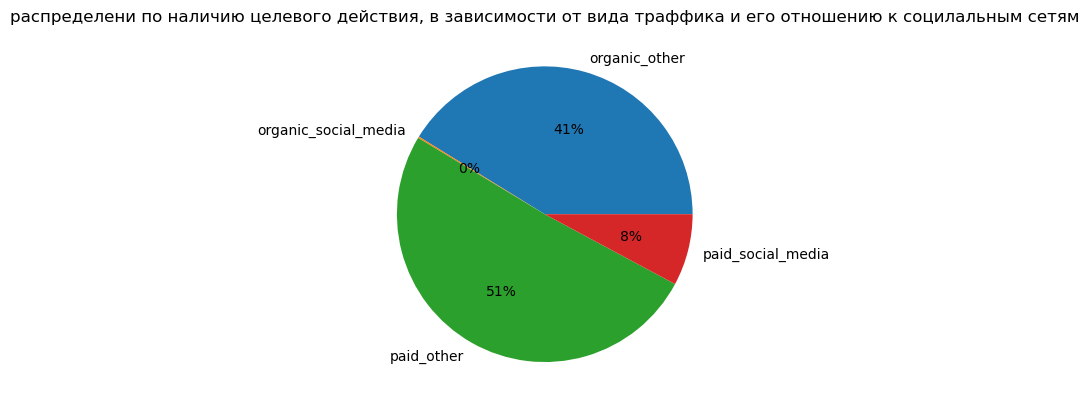

In [173]:
plt.pie(stats2_target['count'], labels=stats2_target['label'], autopct='%1.0f%%')
plt.title('распределени по наличию целевого действия, в зависимости от вида траффика и его отношению к социлальным сетям')
plt.show();

Доля визитов с целевым действием из социальных сетей выше среди платного трафика - 8%, Среди органического трафика данный показатель незначителен.

Посмотрим на конверсию визитов из социальных сетей более подробно. 

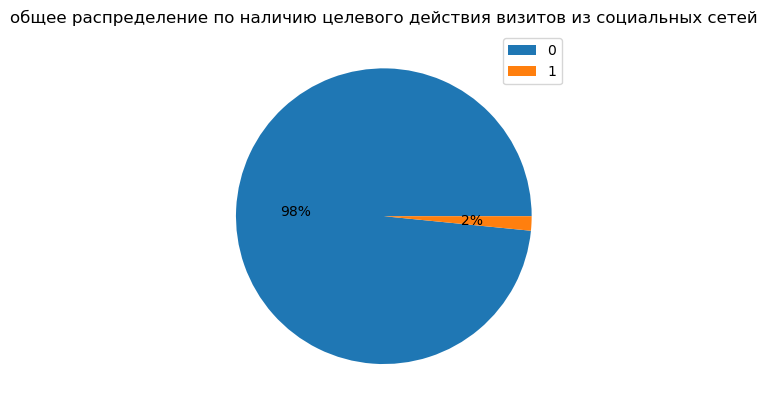

   target   count
0       0  252259
1       1    4021


In [174]:
stats_target = df[df_cleaned['social_media'] == 'yes'].groupby(['target'], as_index=False)['session_id'].count()
stats_target = stats_target.rename(columns={'session_id': 'count'})

plt.pie(stats_target['count'], labels=stats_target['target'], labeldistance=None, autopct='%1.0f%%')
plt.legend()
plt.title('общее распределение по наличию целевого действия визитов из социальных сетей')
plt.show();

print(stats_target)

Проверим, есть ли разница в конверсии с социальных сетей, при разном виде трафика.

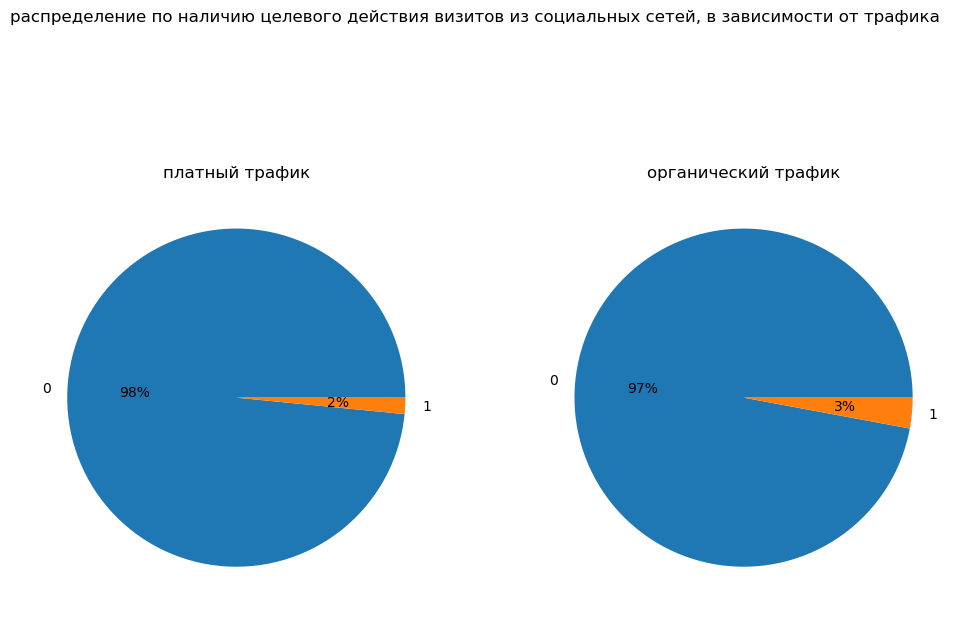

In [175]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

stats_target = []
for traffic in ['paid', 'organic']:
    stats = df[(df['social_media'] == 'yes') & (df['traffic'] == traffic)].groupby(['target'], as_index=False)['session_id'].count()
    stats = stats.rename(columns={'session_id': 'count'})
    stats_target.append(stats)
  
ax1.pie(stats_target[0]['count'], labels=stats_target[0]['target'], autopct='%1.0f%%')
ax1.set_title('платный трафик')

ax2.pie(stats_target[1]['count'], labels=stats_target[1]['target'], autopct='%1.0f%%')
ax2.set_title('органический трафик')

fig.suptitle('распределение по наличию целевого действия визитов из социальных сетей, в зависимости от трафика')
plt.show();

Конверсия из визита с соцальных сетей всего 2%, причем по платному трафику в 1.5 раза ниже. Необходимо проверить, какую аудиторию охватывают ресурсы социальных сетей, где размещается реклама. 
Например, возможно аудитория групп или каналов, где показывается реклама, не заинтересована в предлагаемом продукте. В таком случае, рекомендуется создать портрет потенциального клиента и подобрать интересующие его ресурсы для размещения рекламы.

На последок проверирим, есть ли зависимость от номера визита посетителя

In [176]:
visit_stats = df.groupby(['visit_number', 'target'], as_index=False)['session_id'].count()
visit_stats = visit_stats.rename(columns={'session_id': 'count'})
visit_stats

,visit_number,target,count
0,1,0,1268733
1,1,1,32366
2,2,0,204560
3,2,1,7610
4,3,0,68777
...,...,...,...
784,559,1,1
785,561,1,1
786,562,1,1
787,563,0,1


<AxesSubplot:xlabel='visit_number', ylabel='count'>

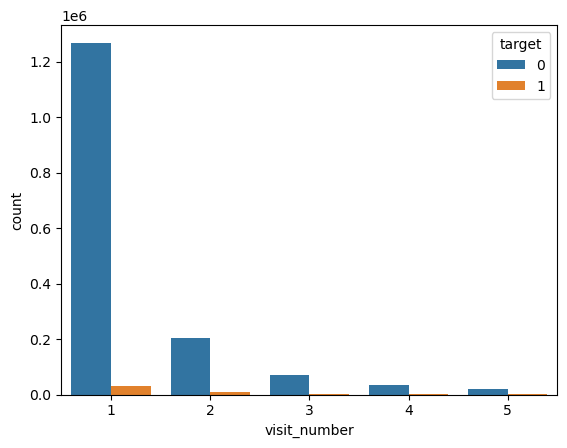

In [177]:
sb.barplot(x="visit_number",
           y="count",
           hue="target",
           data=visit_stats.head(10))

_судя по всему, при повторных посещениях, вероятность целевого действия увеличивается, но не существенно._

Выводы:
1. Проводимые рекламные компании значительно увеличивают трафик сайта, но подавляющая часть посетителей не заинтересована в продукте.
2. Общая конверсия визита в целевое действие составляет 3%
3. Конверсия визитов по органическому трафику выше, относительно платного, но не значительно - 4,4% к 2,3%.
4. Конверсия из визитов с социальных сетей варьируется от 2 до 3%, в зависимости от трафика. Общая доля среди визитов с целевым действием составляет - 8%.
5. Половину целевых действий генерирует платный трафик на различных ресурсах, плюс 8% приносит платная реклама в социальных сетях, остальные 41% приходят сами, либо по реферальным ссылкам.

# Feature engineering

In [34]:
# Загрузим датафрейм
with open(f'{path}/df_cleaned.pkl', 'rb') as file:
    df = dill.load(file)

In [14]:
df.device_screen_resolution.nunique()

4947

Столбец "device_screen_resolution" хоть и имеет явную зависимость к целевой переменной, его значимость ущеляет тот факт, что он содержит косвенную информацию из столбцов "device_brand" и "device_category".  Принимая во внимание количество его 4947 уникальных значений, имеет смысл удалить его из датасета для обучения, так как после кодирования он сгенерирует дополнительные 4947 столбцов и значительно утяжалит датасет.

In [35]:
df = df.drop('device_screen_resolution', axis=1)

97% целевых действий происходит производят пользователи привлеченные из России. 
Создадим новую фичу "from_russia"  в которой укажем "1" для визитов из России и "0" для остальных визитов.
Исходный столбец "geo_country" - удалим.

In [36]:
df['from_russia'] = df.apply(lambda x: 1 if x.geo_country == "Russia" else 0, axis=1)

In [37]:
# проверяем, коррекность созданного столбца.
df[['geo_country', 'from_russia']]

,geo_country,from_russia
0,Russia,1
1,Russia,1
2,Russia,1
3,Russia,1
4,Russia,1
...,...,...
1860037,Russia,1
1860038,Russia,1
1860039,Russia,1
1860040,Russia,1


In [38]:
# удаляем исходный столбец geo_country, он больше не нужен
df = df.drop('geo_country', axis=1)

Преобразуем данные в столбце social_media, вместо "yes" проставим 1, а вместо "no" - 0. Таким образом уменьшим тренировочный датасет на один столбец

In [39]:
df['social_media'] = df['social_media'].apply(lambda x: 1 if x == 'yes' else 0)
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_campaign,utm_adcontent,device_category,device_brand,device_browser,geo_city,target,traffic,social_media,from_russia
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,Chrome,Zlatoust,0,paid,0,1
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,Samsung Internet,Moscow,0,paid,1,1
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,Chrome,Krasnoyarsk,0,paid,0,1
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,other,NOBKLgtuvqYWkXQHeYWM,mobile,Xiaomi,Chrome,Moscow,0,paid,0,1
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,other,(none),mobile,Xiaomi,Chrome,Moscow,0,paid,0,1


Столбцы "geo_country" и "geo_city" зависимы друг от друга, так как город не может быть в нескольких странах одновременно. Создадим объединим их в один столбец "geo_full". Исходные столбцы удалим.

In [230]:
df['geo_full'] = df.apply(lambda x: f'{x.geo_country}: {x.geo_city}', axis=1)
df = df.drop(columns=[ "geo_country", "geo_city"])

Для дальнейшего удобства, переименуем столбцы "traffic" и "social_media", добавив к ним префикс "utm_".

In [44]:
df = df.rename(columns={'traffic': 'utm_traffic', 'social_media': 'utm_social_media'})

In [234]:
# Сохраним в переменную categorical_features имена всех категориальных признаков нашего датасета и оставим только атрибуты для модели
#categorical_features = df.select_dtypes(include=['object']).columns
#categorical_features = categorical_features[4:]
#categorical_features

In [45]:
df.columns

Index(['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number',
       'utm_campaign', 'utm_adcontent', 'device_category', 'device_brand',
       'device_browser', 'geo_city', 'target', 'utm_traffic',
       'utm_social_media', 'from_russia'],
      dtype='object')

In [46]:
# удалим, не нужные для обучения, столбцы
cols_to_drop = ['session_id', 
                'client_id',
                'visit_date',
                'visit_time',
                'visit_number']
df = df.drop(cols_to_drop, axis=1)

In [47]:
# Кодируем категориальные фичи с помощью get_dummies
ohe = pd.get_dummies(df.drop(columns=['target']))
ohe.head()

,from_russia,utm_campaign_AdtHYglxfCpTpwZeTAuW,utm_campaign_AqudXfUnmXWSDWVGYaXr,utm_campaign_BAZCuyHZnaPrMGOMrcCQ,utm_campaign_BHcvLfOaCWvWTykYqHVe,utm_campaign_BHqsCPwtnpaQSryaVXya,utm_campaign_BKeImrJuRDZcHiSSTdzm,utm_campaign_BTRXXRKRDzPJDwsbtyIL,utm_campaign_BVKxkCOHKUOvkpbrLMgZ,utm_campaign_BrdyisDlGWoQTEpGunCI,...,geo_city_Zvenyhorodka,geo_city_Zwickau,geo_city_Zwolle,geo_city_Тарасовка,geo_city_Тимофеевка,geo_city_Хомутово,utm_traffic_organic,utm_traffic_paid,utm_social_media_0,utm_social_media_1
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [48]:
# добавим кодировнные данные в наш датафрейм, удалив при этом не нужные столбцы
df_ohe = pd.concat([df['target'], ohe], axis=1)
df_ohe.head()

,target,from_russia,utm_campaign_AdtHYglxfCpTpwZeTAuW,utm_campaign_AqudXfUnmXWSDWVGYaXr,utm_campaign_BAZCuyHZnaPrMGOMrcCQ,utm_campaign_BHcvLfOaCWvWTykYqHVe,utm_campaign_BHqsCPwtnpaQSryaVXya,utm_campaign_BKeImrJuRDZcHiSSTdzm,utm_campaign_BTRXXRKRDzPJDwsbtyIL,utm_campaign_BVKxkCOHKUOvkpbrLMgZ,...,geo_city_Zvenyhorodka,geo_city_Zwickau,geo_city_Zwolle,geo_city_Тарасовка,geo_city_Тимофеевка,geo_city_Хомутово,utm_traffic_organic,utm_traffic_paid,utm_social_media_0,utm_social_media_1
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [49]:
# сохраним наш датафрейм для обучения модели
with open(f'{path}/df_ohe.pkl', 'wb') as file:
    dill.dump(df_ohe, file)

Если недостаточно памяти, для продолжения, здесь нужно перезагрузить ядро и выполнить первый раздел.

In [50]:
df_ohe.head()

,target,from_russia,utm_campaign_AdtHYglxfCpTpwZeTAuW,utm_campaign_AqudXfUnmXWSDWVGYaXr,utm_campaign_BAZCuyHZnaPrMGOMrcCQ,utm_campaign_BHcvLfOaCWvWTykYqHVe,utm_campaign_BHqsCPwtnpaQSryaVXya,utm_campaign_BKeImrJuRDZcHiSSTdzm,utm_campaign_BTRXXRKRDzPJDwsbtyIL,utm_campaign_BVKxkCOHKUOvkpbrLMgZ,...,geo_city_Zvenyhorodka,geo_city_Zwickau,geo_city_Zwolle,geo_city_Тарасовка,geo_city_Тимофеевка,geo_city_Хомутово,utm_traffic_organic,utm_traffic_paid,utm_social_media_0,utm_social_media_1
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


# Modeling

In [3]:
# загружаем наш датафрейм
with open(f'{path}/df_ohe.pkl', 'rb') as file:
    df_ohe = dill.load(file)

In [4]:
# заведем переменные для обучения
x = df_ohe.drop(columns=['target'])
y = df_ohe['target']

In [5]:
# Посмотрим на сколько сбалансированы получившиеся данные
y.value_counts()

0    1681881
1      50309
Name: target, dtype: int64

In [20]:
# протестируем 2 модели: логистическую регрессию и случайный лес, и выведем метрику accuracy с ее стандартным отклонением
# чтобы сбалансировать данные используем параметр class_weight='balanced'
models = [
    LogisticRegression(solver='liblinear', class_weight='balanced', n_jobs=-1, random_state=42),
    RandomForestClassifier(class_weight='balanced', n_jobs=-1, oob_score=True, random_state=42)
]

for m in models:
    score = cross_val_score(m, x, y, cv=4, scoring='accuracy')
    print(f'model: {type(m).__name__}, acc_mean: {score.mean():.4f}, acc_std: {score.std():.4f}')

c:\Users\1\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
c:\Users\1\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
c:\Users\1\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
c:\Users\1\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


model: LogisticRegression, acc_mean: 0.5367, acc_std: 0.0033
model: RandomForestClassifier, acc_mean: 0.6048, acc_std: 0.0023


_Стандартные отклонения не велики, модели не переобучены._

Обучим модели на тренировочной выборке и построим графики ROC кривых для каждой модели на тестовых выборках.

In [5]:
# разделим датасет на тренировочную и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

''' заведем новую переменную "class_weight" и, так как только 3% данных попадают под класс "1", 
укажем в ней вес 33.3 для класса 1 и единицу для класса 0.'''
class_weight = {0:1, 1:33}

In [6]:
# Обучим модель логистической регрессии на тестовой выборке
logreg = LogisticRegression(solver='liblinear', class_weight=class_weight, n_jobs=16, random_state=42)
logreg.fit(x_train, y_train)

c:\Users\1\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


LogisticRegression(class_weight={0: 1, 1: 33}, n_jobs=16, random_state=42,
                   solver='liblinear')

In [12]:
# Сделаем предикт на тестовой выборке и проверим метрикой accuracy:
# получаем вероятности предсказаний
logreg_probs = logreg.predict_proba(x_test)
# сохраняем вероятности только для положительного исхода
logreg_probs = logreg_probs[:,1]
# рассчитываем метрики
logreg_auc = roc_auc_score(y_test, logreg_probs)
print('LogisticRegression: ROC AUC=%.3f' % (logreg_auc))
print('Accuracy=%.3f' % (accuracy_score(y_test, logreg.predict(x_test))))
print('Confusion_matrix:',"\n", confusion_matrix(y_test, logreg.predict(x_test)))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, logreg_probs)
roc_auc = auc(fpr, tpr)

LogisticRegression: ROC AUC=0.667
Accuracy=0.545
Confusion_matrix: 
 [[272700 231996]
 [  4430  10531]]


In [8]:
# Обучим модель случайного леса на тренировочной выборке
RFC = RandomForestClassifier(class_weight=class_weight, n_jobs=-1, oob_score=True, random_state=42)
RFC.fit(x_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 33}, n_jobs=-1, oob_score=True,
                       random_state=42)

In [9]:
# Сделаем предикт на всей выборке и проверим метрикой accuracy:
# получаем предсказания
RFC_probs = RFC.predict_proba(x_test)
# сохраняем вероятности только для положительного исхода
RFC_probs = RFC_probs[:,1]
# рассчитываем метрики
RFC_auc = roc_auc_score(y_test, RFC_probs)
print('RFC: ROC AUC=%.3f' % (RFC_auc))
print('Accuracy=%.3f' % (accuracy_score(y_test, RFC.predict(x_test))))
print('Confusion_matrix:',"\n", confusion_matrix(y_test, RFC.predict(x_test)))
# рассчитываем roc-кривую
fpr2, tpr2, treshold2 = roc_curve(y_test, RFC_probs)
roc_auc2 = auc(fpr2, tpr2)

RFC: ROC AUC=0.642
Accuracy=0.619
Confusion_matrix: 
 [[312734 191962]
 [  5970   8991]]


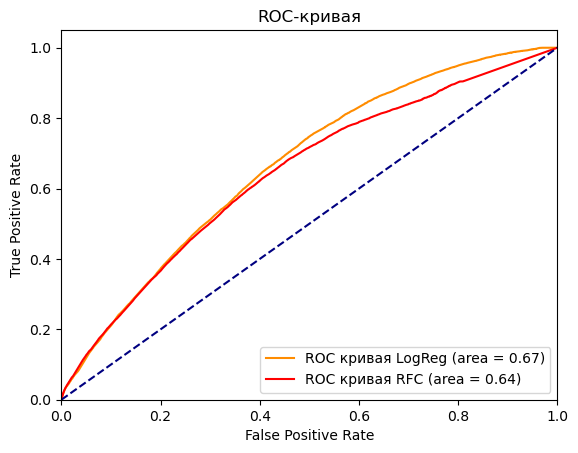

In [10]:
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая LogReg (area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='red',
         label='ROC кривая RFC (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

_лучшие метрики показала модель логистической регресии, остановимся на ней для дальнейшего обучения__

In [11]:
# сохраним модель
with open(f'models/logreg.pkl', 'wb') as file:
    dill.dump(logreg, file)

# TEST TEST TEST TEST